In [1]:
# Set the backend to legacy keras as this is what the pre-trained model expects
# Reduce TensorFlow warnings
# Set backend to TensorFlow
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision, layers
from transformers import TFViTModel
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
import re
from skimage import transform
import os, cv2
import nibabel as nib
from skimage.transform import resize
from skopt import BayesSearchCV
from skopt.space import Categorical
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

2025-09-29 20:03:29.878420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759140209.895535 2628123 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759140209.900787 2628123 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759140209.913351 2628123 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759140209.913373 2628123 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759140209.913375 2628123 computation_placer.cc:177] computation placer alr

In [3]:
# Set memory growth for GPUs
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


## Preprocessing: Extract 2D slices from 3D OCT volumes

In [4]:
# Set the classes based on folder names
CLASSES = ("AD", "CO", "YA", "AQ")

def infer_class(path: str) -> str:
    """Function infer_class to infer class from file path

        Args:
            path (str): File path

        Returns:
            str: Inferred class label

    """

    parent = os.path.basename(os.path.dirname(path)).upper()
    # infer class from parent folder name
    for c in CLASSES:
        if parent.startswith(c):
            return c
    return "UNKNOWN"

def load_volume_like(path: str) -> np.ndarray:
    """Function load_volume_like to load 3D volume or 2D image

        Args:
            path (str): File path

        Returns:
            np.ndarray: Loaded volume or image with shape (H, W, D) or (H, W, 1)

    """
    # load 3D volume or 2D image
    p = path.lower()
    # NIfTI or HDR format
    if p.endswith((".hdr", ".nii", ".nii.gz")):
        vol = nib.load(path).get_fdata()
        vol = np.asarray(vol, dtype=np.float32)
        # (H,W,D) or (H,W,D,1)
        if vol.ndim == 4:
            vol = vol[..., 0]
        if vol.ndim == 2:
            vol = vol[..., None]
        if vol.ndim != 3:
            raise ValueError(f"Unsupported dims {vol.ndim} for {path}")
        return vol
    # DICOM format
    else:
        # DICOM series in a folder
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        # single 2D image
        if img is None:
            raise ValueError(f"Failed to read: {path}")
        # convert to grayscale if needed
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img.astype(np.float32)[..., None]

def normalize01(x: np.ndarray) -> np.ndarray:
    """Function normalize01 to normalize array to [0, 1]

        Args:
            x (np.ndarray): Input array

        Returns:
            np.ndarray: Normalized array

    """
    m = float(x.max())
    # avoid division by zero
    return x / m if m > 0 else x

def center_k_indices(D: int, k: int) -> np.ndarray:
    """Function center_k_indices to get k center slice indices

        Args:
            D (int): Total number of slices
            k (int): Number of center slices to extract

        Returns:
            np.ndarray: Array of k center slice indices

    """
    # ensure k is at least 1 and at most D
    k = max(1, int(k))
    # ensure k does not exceed D
    c = D // 2
    half = k // 2
    # compute start and end indices
    start = max(0, c - half)
    end = min(D, start + k)
    # adjust start if end exceeds D
    start = max(0, end - k)
    return np.arange(start, end, dtype=int)

def nonempty_mask(vol: np.ndarray, min_nonzero_ratio=0.01, min_std=1e-6) -> np.ndarray:
    """Function nonempty_mask to get indices of non-empty slices

        Args:
            vol (np.ndarray): Input volume with shape (H, W, D)
            min_nonzero_ratio (float): Minimum ratio of non-zero pixels to consider a slice non-empty
            min_std (float): Minimum standard deviation to consider a slice non-empty

        Returns:
            np.ndarray: Array of indices of non-empty slices

    """
    # vol is (H, W, D)
    H, W, D = vol.shape
    keep = []
    # check each slice
    for z in range(D):
        sl = vol[..., z]
        if (np.count_nonzero(sl) / (H * W) >= min_nonzero_ratio) and (sl.std() >= min_std):
            keep.append(z)
    return np.array(keep, dtype=int)

def extract_slices(
    address,
    out_root="./oct_slices_pretrained",
    image_size=(50, 50),
    slice_strategy="k_center",
    k_center=5,
    min_nonzero_ratio=0.01,
    min_std=1e-6,
    dry_run=False,
    verbose=True
):
    """Function extract_slices to extract 2D slices from 3D volumes

        Args:
            address (str): Root directory containing 3D volumes
            out_root (str): Output directory to save extracted slices
            image_size (tuple): Desired image size (H, W) for the output slices
            slice_strategy (str): Strategy to select slices ("middle", "k_center", "all_nonempty")
            k_center (int): Number of center slices to extract if slice_strategy is "k_center"
            min_nonzero_ratio (float): Minimum ratio of non-zero pixels to consider a slice non-empty
            min_std (float): Minimum standard deviation to consider a slice non-empty
            dry_run (bool): If True, only scan files without saving
            verbose (bool): If True, print progress and summary

        Returns:
            total (int): Total number of extracted slices
            per_class (dict): Dictionary with counts of extracted slices per class

    """
    # scan for supported files
    supported = (".hdr", ".nii", ".nii.gz", ".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".dcm")
    paths = []
    for root, _, files in os.walk(address):
        for f in files:
            if f.lower().endswith(supported):
                paths.append(os.path.join(root, f))
    if verbose:
        print(f"Found {len(paths)} files under {address}")

    if not dry_run:
        for c in CLASSES:
            os.makedirs(os.path.join(out_root, c), exist_ok=True)
    # process each file
    total = 0
    per_class = {c: 0 for c in CLASSES}
    per_class["UNKNOWN"] = 0
    # sort paths for reproducibility
    for path in paths:
        cls = infer_class(path)
        vol = load_volume_like(path)
        vol = normalize01(vol)
        H, W, D = vol.shape

        # extract middle slice
        if slice_strategy == "middle":
            idxs = np.array([D // 2], dtype=int)
        # extract k center slices
        elif slice_strategy == "k_center":
            idxs = center_k_indices(D, k_center)
        # extract all non-empty slices
        elif slice_strategy == "all_nonempty":
            idxs = nonempty_mask(vol, min_nonzero_ratio, min_std)
            if idxs.size == 0:
                idxs = np.array([D // 2], dtype=int)
        else:
            raise ValueError("slice_strategy must be 'middle', 'k_center', or 'all_nonempty'")

        # update counts
        total += len(idxs)
        # update per-class counts
        per_class[cls] = per_class.get(cls, 0) + len(idxs)

        if not dry_run and cls in CLASSES:
            base = os.path.splitext(os.path.basename(path))[0]
            out_dir = os.path.join(out_root, cls)
            for z in idxs:
                sl = vol[..., z]
                sl = resize(sl, image_size, order=1, preserve_range=True, anti_aliasing=True)
                sl = normalize01(sl)
                out_path = os.path.join(out_dir, f"{base}_z{z:03d}.png")
                cv2.imwrite(out_path, (sl * 255).astype(np.uint8))

    if verbose:
        print(f"Summary (dry_run={dry_run}): total={total}, per_class={per_class}")
    return total, per_class

if __name__ == "__main__":
    DATA_DIR = "./[[[OCT RAW FOR DRYAD]]][2020-01JAN-16]"
    extract_slices(
        address=DATA_DIR,
        out_root="./oct_slices_pretrained_fine_tuning_224_in21k",
        image_size=(224, 224),
        # This refers to the way the 3D images will be sliced into 2D images
        slice_strategy="k_center",
        # Number of center slices to extract if slice_strategy is "k_center"
        k_center=5,
        dry_run=False,
        verbose=True,
    )
# extracted 2D slice image is not appropriate for the dataset. It shows a xy graph
out_root = "./oct_slices_pretrained_fine_tuning_224_in21k"
target = os.path.join(out_root, "CO", "CO100_DARK_MARKED_vertex_z000.png")

if os.path.exists(target):
    os.remove(target)
    print("Deleted:", target)

Found 377 files under ./[[[OCT RAW FOR DRYAD]]][2020-01JAN-16]
Summary (dry_run=False): total=1849, per_class={'AD': 552, 'CO': 549, 'YA': 632, 'AQ': 116, 'UNKNOWN': 0}
Deleted: ./oct_slices_pretrained_fine_tuning_224_in21k/CO/CO100_DARK_MARKED_vertex_z000.png


## Dataloader: Load 2D slices for training

In [5]:
# Supported image extensions
SUPPORTED_IMG_EXTS = ('.png')

def _cohort_from_path(path: str) -> str:
    """Function _cohort_from_path to infer cohort from file path

        Args:
            path (str): File path

        Returns:
            str: Inferred cohort label

    """
    # infer cohort from parent folder name
    parent = os.path.basename(os.path.dirname(path)).upper()
    for k in ('AD', 'CO', 'YA', 'AQ'):
        if parent.startswith(k):
            return k
    return 'UNKNOWN'

def _label_from_cohort(cohort: str, scheme: str = 'binary') -> int:
    """Function _label_from_cohort to map cohort to label

        Args:
            cohort (str): Cohort label
            scheme (str): Labeling scheme ('binary' or 'multi')

        Returns:
            int: Mapped label

    """
    # map cohort to label
    if scheme == 'binary':
        return 1 if cohort == 'AD' else 0
    mapping = {'AD': 0, 'CO': 1, 'YA': 2, 'AQ': 3}
    return mapping.get(cohort, -1)

def _subject_id_from_path(path: str) -> str:
    """Function _subject_id_from_path to extract subject ID from file path

        Args:
            path (str): File path

        Returns:
            str: Extracted subject ID

    """
    # extract subject ID from parent folder or filename
    parent = os.path.basename(os.path.dirname(path))
    m = re.search(r'(\d+)', parent)
    if m:
        return f"{parent[:2].upper()}{m.group(1)}"
    base = os.path.splitext(os.path.basename(path))[0]
    m = re.search(r'(\d+)', base)
    return m.group(1) if m else base

def _normalize01(img: np.ndarray) -> np.ndarray:
    """Function _normalize01 to normalize image to [0, 1]

        Args:
            img (np.ndarray): Input image

        Returns:
            np.ndarray: Normalized image

    """
    # normalize to [0, 1]
    m = img.max() if img.size else 1.0
    return img / (m if m != 0 else 1.0)

def load_any_image(path, image_size):
    """Function load_any_image to load and preprocess an image

        Args:
            path (str): File path
            image_size (tuple): Desired image size (H, W, C)

        Returns:
            np.ndarray: Preprocessed image

    """
    # load image and resize to image_size
    H, W, C = image_size
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # ensure image is read correctly
    if img is None:
        raise ValueError(f"Failed to read image: {path}")
    # convert to float32
    img = img.astype('float32')
    # normalize to [0, 1]
    img = _normalize01(img)
    # ensure 3 channels
    if C == 1:
        img = img[:, :, None]
    else:
        img = np.repeat(img[:, :, None], C, axis=2)
    # resize to (H, W, C)
    img_resized = transform.resize(
        img, (H, W, C), order=1, preserve_range=True, anti_aliasing=True
    ).astype('float32')
    return img_resized

def read_data(image_size=(50, 50, 1), address='./oct_slices_pretrained_fine_tuning_224_in21k', flip=False, debug=False, label_scheme='binary'):
    """Function read_data to load dataset from directory

        Args:
            image_size (tuple): Desired image size (H, W, C)
            address (str): Root directory containing images
            flip (bool): If True, augment data by horizontal flipping
            debug (bool): If True, print debug information
            label_scheme (str): Labeling scheme ('binary' or 'multi')

        Returns:
            X (np.ndarray): Loaded images of shape (N, H, W, C)
            y (np.ndarray): Corresponding labels of shape (N,)
            paths (list): List of file paths for each image
            groups (np.ndarray): Array of subject IDs for each image

    """
    # scan for image files
    paths = []
    for root, _, files in os.walk(address):
        for f in files:
            if f.lower().endswith(SUPPORTED_IMG_EXTS):
                paths.append(os.path.join(root, f))
    if debug:
        print(f"[scan] {address} -> {len(paths)} files")
    if not paths:
        raise RuntimeError(f"No images found under '{address}'")

    # load and preprocess images
    X, y, keep_paths, groups = [], [], [], []
    for p in paths:
        cohort = _cohort_from_path(p)
        lbl = _label_from_cohort(cohort, scheme=label_scheme)
        if lbl < 0:
            if debug:
                print(f"[skip] Unknown cohort for {p}")
            continue
        # load image
        img = load_any_image(p, image_size)
        X.append(img); y.append(lbl); keep_paths.append(p)
        groups.append(_subject_id_from_path(p))

        # data augmentation by flipping
        if flip:
            flipped = cv2.flip(img, 1)
            X.append(flipped); y.append(lbl); keep_paths.append(p + " [flipped]")
            groups.append(_subject_id_from_path(p))

    # convert to numpy arrays
    X = np.stack(X, axis=0).astype('float32')
    # flatten y to 1D array
    y = np.asarray(y, dtype=np.int64)
    # paths
    groups = np.asarray(groups)

    # debug info
    if label_scheme == 'binary' and debug:
        frac_ad = (y == 1).mean()
        print(f"Fraction AD: {frac_ad:.3f} ({(y==1).sum()}/{len(y)})")

    return X, y, keep_paths, groups

# test the dataloader
if __name__ == "__main__":
    X, y, paths, groups = read_data(debug=True)
    print("Loaded:", X.shape, y.shape, len(paths), groups.shape)


[scan] ./oct_slices_pretrained_fine_tuning_224_in21k -> 1848 files
Fraction AD: 0.299 (552/1848)
Loaded: (1848, 50, 50, 1) (1848,) 1848 (1848,)


## Vision Transformer (ViT) model for classification

In [6]:
# Parameters for training such as dropout rate, learning rate, head units, weight decay, batch size can be adjusted in the BayesSearchCV section.
class PretrainedViTWrapper(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"
    def __init__(
        self,
        # Pretrained ViT model name from Hugging Face
        model_name="google/vit-base-patch16-224-in21k",
        head_units=32,
        dropout_rate=0.3,
        # change epochs as needed
        epochs=100,
        batch_size=4,
        lr=1e-4,
        weight_decay=0,
        # Change to None if using focal loss
        class_weight="balanced",
        logdir_root=None,
        random_state=42,
    ):
        """Function __init__ to initialize the PretrainedViTWrapper

            Args:
                model_name (str): Name of the pretrained ViT model from Hugging Face
                head_units (int): Number of units in the classification head
                dropout_rate (float): Dropout rate for regularization
                epochs (int): Number of training epochs
                batch_size (int): Batch size for training
                lr (float): Learning rate for the optimizer
                weight_decay (float): Weight decay for the optimizer
                class_weight (str or None): Class weighting scheme ('balanced' or None)
                logdir_root (str or None): Root directory for TensorBoard logs
                random_state (int): Random seed for reproducibility

        """
        self.model_name = model_name
        self.head_units = head_units
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.class_weight = class_weight
        self.logdir_root = logdir_root
        self.random_state = random_state

    def _build_model(self, input_shape):
        """Function _build_model to build the Keras model

            Args:
                input_shape (tuple): Shape of the input images (H, W, C)

            Returns:
                model (keras.Model): Compiled Keras model

        """
        # Input layer
        inp = tf.keras.Input(shape=input_shape, name="oct_50x50x1")

        x = inp

        # 1 channel -> 3 channels
        if input_shape[-1] == 1:
            x = layers.Concatenate(axis=-1, name="to_rgb")([x, x, x])
        else:
            x = layers.Lambda(lambda t: t[..., :3], name="keep_rgb")(x)

        # 50x50 -> 224x224; scale to [-1, 1]
        x = layers.Resizing(224, 224, interpolation="bilinear", name="resize_224")(x)
        x = layers.Rescaling(2.0, offset=-1.0, name="to_minus1_plus1")(x)

        # NHWC -> NCHW (ViT expects channels-first before it transposes internally)
        x = layers.Permute((3, 1, 2), name="to_nchw")(x)

        # Load pretrained ViT model
        vit = TFViTModel.from_pretrained(self.model_name)
        vit.trainable = False

        # Unfreeze last 2 transformer blocks for fine-tuning
        num_layers = vit.config.num_hidden_layers
        for i, block in enumerate(vit.vit.encoder.layer):
            block.trainable = (i >= num_layers - 2)

        # ViT backbone
        seq = vit(pixel_values=x).last_hidden_state
        cls = layers.Lambda(lambda t: t[:, 0])(seq)

        # Classification head
        h = layers.Dropout(self.dropout_rate)(cls)
        h = layers.Dense(self.head_units, activation=tf.keras.activations.gelu)(h)
        h = layers.Dropout(self.dropout_rate)(h)

        # Single output with sigmoid for binary classification
        # Changed to float32 to avoid dtype issues with mixed precision
        out = layers.Dense(1, activation="sigmoid", dtype="float32")(h)

        # Compile model
        model = tf.keras.Model(inp, out, name="ViT_B16_224_finetune")

        # Focal loss was tried but did poorly compared to binary crossentropy
        # If using focal loss, class_weight should be None as focal loss handles class imbalance
        # jit_compile=False to avoid issues with some custom losses
        opt = tf.keras.optimizers.AdamW(learning_rate=self.lr, weight_decay=self.weight_decay)
        model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(), "accuracy"], jit_compile=False, steps_per_execution=32)
        return model

    def fit(self, X, y):
        """Function fit to train the model

            Args:
                X (np.ndarray): Input images of shape (N, H, W, C)
                y (np.ndarray): Binary labels of shape (N,)

            Returns:
                self: Fitted estimator

        """
        # Reproducibility
        tf.keras.backend.clear_session()
        tf.random.set_seed(self.random_state)
        np.random.seed(self.random_state)

        # Build and compile model
        self.classes_ = np.array([0, 1], dtype=int)
        self.n_classes_ = 2
        self.model_ = self._build_model(input_shape=X.shape[1:])

        # Callbacks
        # Early stopping, model checkpoint, TensorBoard
        cbs = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),tf.keras.callbacks.ModelCheckpoint(
        "vit_pretrained_finetuning.weights.h5",
        monitor="loss", save_best_only=True, save_weights_only=True
    ),]
        if self.logdir_root:
            os.makedirs(self.logdir_root, exist_ok=True)
            run_dir = os.path.join(self.logdir_root, time.strftime("%Y%m%d-%H%M%S"))
            cbs.append(tf.keras.callbacks.TensorBoard(log_dir=run_dir, write_graph=False))

        # Class weights
        cw = None
        if self.class_weight == "balanced":
            w = compute_class_weight(class_weight="balanced", classes=self.classes_, y=y.ravel())
            cw = {0: float(w[0]), 1: float(w[1])}

        # Train model
        self.model_.fit(
            X, y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=2,
            validation_split=0,
            callbacks=cbs,
            class_weight=cw,
        )
        return self

    def predict_proba(self, X):
        """Function predict_proba to get class probabilities

            Args:
                X (np.ndarray): Input images of shape (N, H, W, C)

            Returns:
                np.ndarray: Class probabilities of shape (N, 2)

        """
        # Predict probabilities for the positive class
        p = self.model_.predict(X, verbose=0).ravel()
        # Ensure probabilities are within [1e-7, 1-1e-7] for numerical stability
        p = np.clip(p, 1e-7, 1 - 1e-7)
        return np.column_stack([1.0 - p, p])

    def predict(self, X):
        """Function predict to get class labels

            Args:
                X (np.ndarray): Input images of shape (N, H, W, C)

            Returns:
                np.ndarray: Predicted class labels of shape (N,)

        """

        return (self.model_.predict(X, verbose=0).ravel() >= 0.5).astype(int)

    def score(self, X, y):
        """Function score to evaluate the model accuracy

            Args:
                X (np.ndarray): Input images of shape (N, H, W, C)
                y (np.ndarray): True binary labels of shape (N,)

            Returns:
                float: Accuracy score

        """
        return (self.predict(X) == y.ravel()).mean()


# load data from preprocessed slices
DATA_DIR = "./oct_slices_pretrained_fine_tuning_224_in21k"

# Load data
X, y, paths, groups = read_data(
    image_size=(50, 50, 1),
    address=DATA_DIR,
    flip=False,
    debug=False,
    label_scheme="binary",
)
# Flatten y to 1D array of int
y = y.ravel().astype(int)

# Train/test split (group-stratified)
print("Dataset:", X.shape, " AD ratio:", y.mean())
print("Class counts:", Counter(y))

# stratify by y to maintain class balance in train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# print dataset info
print("Train:", X_tr.shape, " Test:", X_te.shape)
print("Train AD ratio:", y_tr.mean(), " Test AD ratio:", y_te.mean())

Dataset: (1848, 50, 50, 1)  AD ratio: 0.2987012987012987
Class counts: Counter({np.int64(0): 1296, np.int64(1): 552})
Train: (1663, 50, 50, 1)  Test: (185, 50, 50, 1)
Train AD ratio: 0.2988574864702345  Test AD ratio: 0.2972972972972973


## Bayesian hyperparameter optimization

In [6]:
# Hyperparameter search space. Adjust as needed. Add more iterations below if needed. Add more variables in the PretrainedViTWrapper class if needed.
# To find a good set of values for search, change from Categorical to Real and use a wide range. Head units should be kept at Categorical and in multiples of 8. Batch size should be kept at Categorical
vit_params = {
    "head_units": Categorical([32, 64]),
    "dropout_rate": Categorical([0.25, 0.3, 0.35, 0.4]),
    "batch_size": Categorical([2]),
    "lr": Categorical([2e-5, 5e-5]),
    "weight_decay": Categorical([1e-5, 3e-5, 1e-4, 3e-4]),
}

# Create estimator
estimator = PretrainedViTWrapper(
    logdir_root="tb_logs/vit_pretrained_finetuning",
    class_weight="balanced",
)

# Custom scoring function to use predicted probabilities for ROC AUC instead of Accuracy
def roc_auc_from_proba(estimator, X, y):
    """Function roc_auc_from_proba to compute ROC AUC from predicted probabilities

        Args:
            estimator: Fitted estimator
            X (np.ndarray): Input images of shape (N, H, W, C)
            y (np.ndarray): True binary labels of shape (N,)

        Returns:
            float: ROC AUC score

    """
    p = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, p)

# Bayesian search. Increase n_iter for more thorough search, however at the cost of GPU memory.
search = BayesSearchCV(
    estimator=estimator,
    search_spaces=vit_params,
    n_iter=3,
    cv=cv,
    n_jobs=1,
    # Scoring can be changed to accuracy, however did worse than ROC AUC in trials
    scoring=roc_auc_from_proba,
    refit=True,
    verbose=2,
)

# fit with groups if needed
fit_kwargs = {}


# perform search
t0 = time.time()

# may take a while depending on n_iter and epochs
search.fit(X_tr, y_tr, **fit_kwargs)
print(f"\nBayesSearchCV done in {time.time()-t0:.1f}s")
print("Best CV Accuracy:", search.best_score_)
print("Best params:", search.best_params_)

# get the best estimator
best_est = search.best_estimator_

# best_est.model_ is the trained Keras model
y_prob = best_est.predict_proba(X_te)[:, 1]

# reducing threshold may improve recall. Increase threshold may improve precision.
y_pred = (y_prob >= 0.6).astype(int)

# final evaluation on held-out test set
acc = accuracy_score(y_te, y_pred)
try:
    auc = roc_auc_score(y_te, y_prob)
except Exception:
    auc = float("nan")

# print results
print("\nHELD-OUT TEST RESULTS")
print(" Accuracy:", round(acc, 4))
print(" ROC AUC:", round(auc, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_te, y_pred))
print("\nReport:\n", classification_report(y_te, y_pred, digits=4))

print("\nTo view training logs with TensorBoard:")
print("  tensorboard --logdir tb_logs/vit_pretrained")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


I0000 00:00:1758548606.875575   10075 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6341 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100


I0000 00:00:1758548616.179302   11834 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758548618.417417   11832 service.cc:152] XLA service 0x79e218006590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758548618.417447   11832 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
I0000 00:00:1758548618.595463   11832 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 18s - loss: 0.6923 - auc: 0.5460 - accuracy: 0.5977 - 18s/epoch - 28ms/step
Epoch 2/100
665/665 - 8s - loss: 0.6526 - auc: 0.6902 - accuracy: 0.6256 - 8s/epoch - 13ms/step
Epoch 3/100
665/665 - 8s - loss: 0.6367 - auc: 0.7078 - accuracy: 0.6632 - 8s/epoch - 12ms/step
Epoch 4/100
665/665 - 8s - loss: 0.6172 - auc: 0.7377 - accuracy: 0.6782 - 8s/epoch - 12ms/step
Epoch 5/100
665/665 - 8s - loss: 0.6008 - auc: 0.7558 - accuracy: 0.6782 - 8s/epoch - 12ms/step
Epoch 6/100
665/665 - 8s - loss: 0.5830 - auc: 0.7777 - accuracy: 0.7083 - 8s/epoch - 12ms/step
Epoch 7/100
665/665 - 8s - loss: 0.5754 - auc: 0.7833 - accuracy: 0.7083 - 8s/epoch - 12ms/step
Epoch 8/100
665/665 - 8s - loss: 0.5590 - auc: 0.8024 - accuracy: 0.7391 - 8s/epoch - 12ms/step
Epoch 9/100
665/665 - 8s - loss: 0.5348 - auc: 0.8245 - accuracy: 0.7466 - 8s/epoch - 12ms/step
Epoch 10/100
665/665 - 8s - loss: 0.5344 - auc: 0.8198 - accuracy: 0.7414 - 8s/epoch - 12ms/step
Epoch 11/100
665/665 - 7s - loss: 0.5357 - auc: 0

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 15s - loss: 0.6892 - auc: 0.5559 - accuracy: 0.5571 - 15s/epoch - 22ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 8s - loss: 0.6480 - auc: 0.6950 - accuracy: 0.6323 - 8s/epoch - 12ms/step
Epoch 3/100
665/665 - 8s - loss: 0.6373 - auc: 0.7122 - accuracy: 0.6707 - 8s/epoch - 12ms/step
Epoch 4/100
665/665 - 8s - loss: 0.6139 - auc: 0.7438 - accuracy: 0.7030 - 8s/epoch - 12ms/step
Epoch 5/100
665/665 - 8s - loss: 0.5932 - auc: 0.7721 - accuracy: 0.7105 - 8s/epoch - 12ms/step
Epoch 6/100
665/665 - 8s - loss: 0.5824 - auc: 0.7761 - accuracy: 0.7023 - 8s/epoch - 12ms/step
Epoch 7/100
665/665 - 8s - loss: 0.5640 - auc: 0.7971 - accuracy: 0.7180 - 8s/epoch - 12ms/step
Epoch 8/100
665/665 - 8s - loss: 0.5589 - auc: 0.7990 - accuracy: 0.7248 - 8s/epoch - 12ms/step
Epoch 9/100
665/665 - 8s - loss: 0.5481 - auc: 0.8109 - accuracy: 0.7278 - 8s/epoch - 12ms/step
Epoch 10/100
665/665 - 8s - loss: 0.5378 - auc: 0.8192 - accuracy: 0.7383 - 8s/epoch - 12ms/step
Epoch 11/100
665/665 - 8s - loss: 0.5235 - auc: 0.8328 - accuracy: 0.7579 - 8s/epoch - 12ms/step
Epoch 12/100
665/665 - 8s - loss: 0.5127 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 15s - loss: 0.6847 - auc: 0.5756 - accuracy: 0.6090 - 15s/epoch - 23ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 8s - loss: 0.6513 - auc: 0.6852 - accuracy: 0.6534 - 8s/epoch - 12ms/step
Epoch 3/100
665/665 - 8s - loss: 0.6294 - auc: 0.7224 - accuracy: 0.6774 - 8s/epoch - 12ms/step
Epoch 4/100
665/665 - 8s - loss: 0.6113 - auc: 0.7494 - accuracy: 0.6835 - 8s/epoch - 12ms/step
Epoch 5/100
665/665 - 8s - loss: 0.5976 - auc: 0.7609 - accuracy: 0.6940 - 8s/epoch - 12ms/step
Epoch 6/100
665/665 - 8s - loss: 0.5860 - auc: 0.7707 - accuracy: 0.7248 - 8s/epoch - 12ms/step
Epoch 7/100
665/665 - 8s - loss: 0.5673 - auc: 0.7931 - accuracy: 0.7105 - 8s/epoch - 12ms/step
Epoch 8/100
665/665 - 8s - loss: 0.5633 - auc: 0.7939 - accuracy: 0.7150 - 8s/epoch - 12ms/step
Epoch 9/100
665/665 - 8s - loss: 0.5459 - auc: 0.8148 - accuracy: 0.7421 - 8s/epoch - 12ms/step
Epoch 10/100
665/665 - 8s - loss: 0.5343 - auc: 0.8252 - accuracy: 0.7526 - 8s/epoch - 12ms/step
Epoch 11/100
665/665 - 8s - loss: 0.5187 - auc: 0.8366 - accuracy: 0.7647 - 8s/epoch - 12ms/step
Epoch 12/100
665/665 - 8s - loss: 0.5156 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
666/666 - 27s - loss: 0.6929 - auc: 0.5400 - accuracy: 0.4921 - 27s/epoch - 40ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


666/666 - 16s - loss: 0.6611 - auc: 0.6567 - accuracy: 0.6236 - 16s/epoch - 24ms/step
Epoch 3/100
666/666 - 16s - loss: 0.6364 - auc: 0.7143 - accuracy: 0.6566 - 16s/epoch - 24ms/step
Epoch 4/100
666/666 - 16s - loss: 0.6186 - auc: 0.7415 - accuracy: 0.6829 - 16s/epoch - 24ms/step
Epoch 5/100
666/666 - 16s - loss: 0.5952 - auc: 0.7715 - accuracy: 0.6965 - 16s/epoch - 24ms/step
Epoch 6/100
666/666 - 16s - loss: 0.5811 - auc: 0.7881 - accuracy: 0.7288 - 16s/epoch - 24ms/step
Epoch 7/100
666/666 - 16s - loss: 0.5689 - auc: 0.7955 - accuracy: 0.7137 - 16s/epoch - 24ms/step
Epoch 8/100
666/666 - 16s - loss: 0.5668 - auc: 0.7917 - accuracy: 0.7310 - 16s/epoch - 24ms/step
Epoch 9/100
666/666 - 16s - loss: 0.5640 - auc: 0.7925 - accuracy: 0.7198 - 16s/epoch - 24ms/step
Epoch 10/100
666/666 - 16s - loss: 0.5354 - auc: 0.8254 - accuracy: 0.7483 - 16s/epoch - 25ms/step
Epoch 11/100
666/666 - 16s - loss: 0.5231 - auc: 0.8330 - accuracy: 0.7588 - 16s/epoch - 24ms/step
Epoch 12/100
666/666 - 15s - l

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
666/666 - 27s - loss: 0.6895 - auc: 0.5544 - accuracy: 0.5575 - 27s/epoch - 40ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


666/666 - 16s - loss: 0.6558 - auc: 0.6710 - accuracy: 0.6056 - 16s/epoch - 25ms/step
Epoch 3/100
666/666 - 16s - loss: 0.6353 - auc: 0.7117 - accuracy: 0.6551 - 16s/epoch - 24ms/step
Epoch 4/100
666/666 - 16s - loss: 0.6131 - auc: 0.7495 - accuracy: 0.6799 - 16s/epoch - 24ms/step
Epoch 5/100
666/666 - 16s - loss: 0.5967 - auc: 0.7725 - accuracy: 0.7175 - 16s/epoch - 24ms/step
Epoch 6/100
666/666 - 16s - loss: 0.5789 - auc: 0.7876 - accuracy: 0.7145 - 16s/epoch - 24ms/step
Epoch 7/100
666/666 - 16s - loss: 0.5753 - auc: 0.7839 - accuracy: 0.7032 - 16s/epoch - 24ms/step
Epoch 8/100
666/666 - 16s - loss: 0.5520 - auc: 0.8126 - accuracy: 0.7280 - 16s/epoch - 24ms/step
Epoch 9/100
666/666 - 16s - loss: 0.5403 - auc: 0.8204 - accuracy: 0.7453 - 16s/epoch - 24ms/step
Epoch 10/100
666/666 - 15s - loss: 0.5487 - auc: 0.8072 - accuracy: 0.7220 - 15s/epoch - 23ms/step
Epoch 11/100
666/666 - 16s - loss: 0.5229 - auc: 0.8345 - accuracy: 0.7536 - 16s/epoch - 24ms/step
Epoch 12/100
666/666 - 16s - l

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 16s - loss: 0.7020 - auc: 0.5040 - accuracy: 0.4662 - 16s/epoch - 24ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 9s - loss: 0.6896 - auc: 0.5557 - accuracy: 0.4887 - 9s/epoch - 14ms/step
Epoch 3/100
665/665 - 9s - loss: 0.6877 - auc: 0.5596 - accuracy: 0.5519 - 9s/epoch - 14ms/step
Epoch 4/100
665/665 - 9s - loss: 0.6837 - auc: 0.5739 - accuracy: 0.5421 - 9s/epoch - 14ms/step
Epoch 5/100
665/665 - 9s - loss: 0.6722 - auc: 0.6221 - accuracy: 0.5902 - 9s/epoch - 14ms/step
Epoch 6/100
665/665 - 9s - loss: 0.6637 - auc: 0.6459 - accuracy: 0.6098 - 9s/epoch - 14ms/step
Epoch 7/100
665/665 - 8s - loss: 0.6667 - auc: 0.6379 - accuracy: 0.5940 - 8s/epoch - 12ms/step
Epoch 8/100
665/665 - 9s - loss: 0.6515 - auc: 0.6789 - accuracy: 0.6218 - 9s/epoch - 14ms/step
Epoch 9/100
665/665 - 9s - loss: 0.6478 - auc: 0.6876 - accuracy: 0.6188 - 9s/epoch - 14ms/step
Epoch 10/100
665/665 - 9s - loss: 0.6437 - auc: 0.7009 - accuracy: 0.6459 - 9s/epoch - 14ms/step
Epoch 11/100
665/665 - 8s - loss: 0.6458 - auc: 0.6899 - accuracy: 0.6353 - 8s/epoch - 12ms/step
Epoch 12/100
665/665 - 9s - loss: 0.6367 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 15s - loss: 0.7072 - auc: 0.5159 - accuracy: 0.6060 - 15s/epoch - 23ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 9s - loss: 0.6918 - auc: 0.5488 - accuracy: 0.5985 - 9s/epoch - 13ms/step
Epoch 3/100
665/665 - 9s - loss: 0.6815 - auc: 0.5898 - accuracy: 0.5910 - 9s/epoch - 13ms/step
Epoch 4/100
665/665 - 9s - loss: 0.6753 - auc: 0.6079 - accuracy: 0.6015 - 9s/epoch - 13ms/step
Epoch 5/100
665/665 - 9s - loss: 0.6643 - auc: 0.6527 - accuracy: 0.6383 - 9s/epoch - 13ms/step
Epoch 6/100
665/665 - 8s - loss: 0.6651 - auc: 0.6408 - accuracy: 0.6165 - 8s/epoch - 12ms/step
Epoch 7/100
665/665 - 9s - loss: 0.6620 - auc: 0.6529 - accuracy: 0.6203 - 9s/epoch - 13ms/step
Epoch 8/100
665/665 - 9s - loss: 0.6554 - auc: 0.6680 - accuracy: 0.6346 - 9s/epoch - 13ms/step
Epoch 9/100
665/665 - 9s - loss: 0.6489 - auc: 0.6873 - accuracy: 0.6474 - 9s/epoch - 13ms/step
Epoch 10/100
665/665 - 9s - loss: 0.6442 - auc: 0.6910 - accuracy: 0.6436 - 9s/epoch - 13ms/step
Epoch 11/100
665/665 - 9s - loss: 0.6376 - auc: 0.7063 - accuracy: 0.6669 - 9s/epoch - 13ms/step
Epoch 12/100
665/665 - 8s - loss: 0.6409 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 16s - loss: 0.7052 - auc: 0.4815 - accuracy: 0.4932 - 16s/epoch - 23ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 9s - loss: 0.6966 - auc: 0.5217 - accuracy: 0.5414 - 9s/epoch - 14ms/step
Epoch 3/100
665/665 - 9s - loss: 0.6894 - auc: 0.5580 - accuracy: 0.5594 - 9s/epoch - 14ms/step
Epoch 4/100
665/665 - 9s - loss: 0.6758 - auc: 0.6134 - accuracy: 0.5737 - 9s/epoch - 14ms/step
Epoch 5/100
665/665 - 9s - loss: 0.6683 - auc: 0.6349 - accuracy: 0.6068 - 9s/epoch - 14ms/step
Epoch 6/100
665/665 - 8s - loss: 0.6696 - auc: 0.6264 - accuracy: 0.5985 - 8s/epoch - 12ms/step
Epoch 7/100
665/665 - 9s - loss: 0.6617 - auc: 0.6509 - accuracy: 0.6173 - 9s/epoch - 14ms/step
Epoch 8/100
665/665 - 9s - loss: 0.6494 - auc: 0.6891 - accuracy: 0.6376 - 9s/epoch - 14ms/step
Epoch 9/100
665/665 - 8s - loss: 0.6568 - auc: 0.6644 - accuracy: 0.6301 - 8s/epoch - 12ms/step
Epoch 10/100
665/665 - 9s - loss: 0.6402 - auc: 0.7147 - accuracy: 0.6699 - 9s/epoch - 14ms/step
Epoch 11/100
665/665 - 9s - loss: 0.6353 - auc: 0.7116 - accuracy: 0.6481 - 9s/epoch - 14ms/step
Epoch 12/100
665/665 - 9s - loss: 0.6335 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
666/666 - 27s - loss: 0.7119 - auc: 0.4901 - accuracy: 0.5530 - 27s/epoch - 41ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


666/666 - 16s - loss: 0.6994 - auc: 0.5243 - accuracy: 0.5522 - 16s/epoch - 25ms/step
Epoch 3/100
666/666 - 16s - loss: 0.6940 - auc: 0.5402 - accuracy: 0.5334 - 16s/epoch - 25ms/step
Epoch 4/100
666/666 - 16s - loss: 0.6771 - auc: 0.6062 - accuracy: 0.5868 - 16s/epoch - 25ms/step
Epoch 5/100
666/666 - 16s - loss: 0.6774 - auc: 0.5986 - accuracy: 0.5522 - 16s/epoch - 24ms/step
Epoch 6/100
666/666 - 16s - loss: 0.6709 - auc: 0.6267 - accuracy: 0.6063 - 16s/epoch - 25ms/step
Epoch 7/100
666/666 - 16s - loss: 0.6688 - auc: 0.6358 - accuracy: 0.6018 - 16s/epoch - 25ms/step
Epoch 8/100
666/666 - 16s - loss: 0.6578 - auc: 0.6670 - accuracy: 0.6078 - 16s/epoch - 25ms/step
Epoch 9/100
666/666 - 17s - loss: 0.6556 - auc: 0.6656 - accuracy: 0.6146 - 17s/epoch - 25ms/step
Epoch 10/100
666/666 - 16s - loss: 0.6488 - auc: 0.6834 - accuracy: 0.6236 - 16s/epoch - 25ms/step
Epoch 11/100
666/666 - 16s - loss: 0.6419 - auc: 0.7030 - accuracy: 0.6582 - 16s/epoch - 25ms/step
Epoch 12/100
666/666 - 16s - l

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
666/666 - 26s - loss: 0.7124 - auc: 0.4551 - accuracy: 0.4621 - 26s/epoch - 39ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


666/666 - 16s - loss: 0.6993 - auc: 0.5091 - accuracy: 0.5064 - 16s/epoch - 25ms/step
Epoch 3/100
666/666 - 16s - loss: 0.6843 - auc: 0.5735 - accuracy: 0.5808 - 16s/epoch - 25ms/step
Epoch 4/100
666/666 - 16s - loss: 0.6847 - auc: 0.5762 - accuracy: 0.5687 - 16s/epoch - 24ms/step
Epoch 5/100
666/666 - 16s - loss: 0.6750 - auc: 0.6076 - accuracy: 0.5868 - 16s/epoch - 25ms/step
Epoch 6/100
666/666 - 16s - loss: 0.6810 - auc: 0.5898 - accuracy: 0.5680 - 16s/epoch - 23ms/step
Epoch 7/100
666/666 - 16s - loss: 0.6608 - auc: 0.6553 - accuracy: 0.6086 - 16s/epoch - 25ms/step
Epoch 8/100
666/666 - 16s - loss: 0.6555 - auc: 0.6744 - accuracy: 0.6258 - 16s/epoch - 25ms/step
Epoch 9/100
666/666 - 17s - loss: 0.6549 - auc: 0.6748 - accuracy: 0.6371 - 17s/epoch - 25ms/step
Epoch 10/100
666/666 - 16s - loss: 0.6461 - auc: 0.6915 - accuracy: 0.6311 - 16s/epoch - 25ms/step
Epoch 11/100
666/666 - 16s - loss: 0.6428 - auc: 0.6945 - accuracy: 0.6461 - 16s/epoch - 25ms/step
Epoch 12/100
666/666 - 16s - l

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 16s - loss: 0.7155 - auc: 0.4706 - accuracy: 0.4812 - 16s/epoch - 24ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 9s - loss: 0.7028 - auc: 0.5069 - accuracy: 0.5015 - 9s/epoch - 14ms/step
Epoch 3/100
665/665 - 9s - loss: 0.6897 - auc: 0.5579 - accuracy: 0.5489 - 9s/epoch - 14ms/step
Epoch 4/100
665/665 - 9s - loss: 0.6795 - auc: 0.5859 - accuracy: 0.5684 - 9s/epoch - 14ms/step
Epoch 5/100
665/665 - 9s - loss: 0.6733 - auc: 0.6107 - accuracy: 0.5835 - 9s/epoch - 14ms/step
Epoch 6/100
665/665 - 9s - loss: 0.6674 - auc: 0.6292 - accuracy: 0.5962 - 9s/epoch - 14ms/step
Epoch 7/100
665/665 - 9s - loss: 0.6663 - auc: 0.6366 - accuracy: 0.5842 - 9s/epoch - 14ms/step
Epoch 8/100
665/665 - 9s - loss: 0.6600 - auc: 0.6548 - accuracy: 0.6098 - 9s/epoch - 14ms/step
Epoch 9/100
665/665 - 9s - loss: 0.6492 - auc: 0.6833 - accuracy: 0.6278 - 9s/epoch - 14ms/step
Epoch 10/100
665/665 - 9s - loss: 0.6407 - auc: 0.6968 - accuracy: 0.6444 - 9s/epoch - 14ms/step
Epoch 11/100
665/665 - 9s - loss: 0.6334 - auc: 0.7105 - accuracy: 0.6579 - 9s/epoch - 14ms/step
Epoch 12/100
665/665 - 8s - loss: 0.6361 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 16s - loss: 0.7031 - auc: 0.5143 - accuracy: 0.4910 - 16s/epoch - 24ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 9s - loss: 0.6872 - auc: 0.5665 - accuracy: 0.5444 - 9s/epoch - 14ms/step
Epoch 3/100
665/665 - 9s - loss: 0.6849 - auc: 0.5767 - accuracy: 0.5617 - 9s/epoch - 14ms/step
Epoch 4/100
665/665 - 9s - loss: 0.6752 - auc: 0.6092 - accuracy: 0.6083 - 9s/epoch - 14ms/step
Epoch 5/100
665/665 - 9s - loss: 0.6659 - auc: 0.6495 - accuracy: 0.6226 - 9s/epoch - 14ms/step
Epoch 6/100
665/665 - 9s - loss: 0.6631 - auc: 0.6497 - accuracy: 0.5992 - 9s/epoch - 14ms/step
Epoch 7/100
665/665 - 9s - loss: 0.6596 - auc: 0.6660 - accuracy: 0.6248 - 9s/epoch - 14ms/step
Epoch 8/100
665/665 - 9s - loss: 0.6519 - auc: 0.6827 - accuracy: 0.6331 - 9s/epoch - 14ms/step
Epoch 9/100
665/665 - 9s - loss: 0.6464 - auc: 0.6901 - accuracy: 0.6504 - 9s/epoch - 14ms/step
Epoch 10/100
665/665 - 9s - loss: 0.6451 - auc: 0.6919 - accuracy: 0.6368 - 9s/epoch - 14ms/step
Epoch 11/100
665/665 - 9s - loss: 0.6368 - auc: 0.7104 - accuracy: 0.6594 - 9s/epoch - 14ms/step
Epoch 12/100
665/665 - 9s - loss: 0.6345 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
665/665 - 16s - loss: 0.7049 - auc: 0.5004 - accuracy: 0.4774 - 16s/epoch - 24ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


665/665 - 9s - loss: 0.6959 - auc: 0.5279 - accuracy: 0.5180 - 9s/epoch - 14ms/step
Epoch 3/100
665/665 - 9s - loss: 0.6838 - auc: 0.5750 - accuracy: 0.5451 - 9s/epoch - 14ms/step
Epoch 4/100
665/665 - 9s - loss: 0.6764 - auc: 0.6106 - accuracy: 0.5617 - 9s/epoch - 14ms/step
Epoch 5/100
665/665 - 9s - loss: 0.6629 - auc: 0.6485 - accuracy: 0.6120 - 9s/epoch - 14ms/step
Epoch 6/100
665/665 - 8s - loss: 0.6715 - auc: 0.6255 - accuracy: 0.6030 - 8s/epoch - 13ms/step
Epoch 7/100
665/665 - 9s - loss: 0.6482 - auc: 0.6912 - accuracy: 0.6421 - 9s/epoch - 14ms/step
Epoch 8/100
665/665 - 9s - loss: 0.6413 - auc: 0.7107 - accuracy: 0.6571 - 9s/epoch - 14ms/step
Epoch 9/100
665/665 - 8s - loss: 0.6498 - auc: 0.6810 - accuracy: 0.6436 - 8s/epoch - 13ms/step
Epoch 10/100
665/665 - 9s - loss: 0.6362 - auc: 0.7066 - accuracy: 0.6564 - 9s/epoch - 14ms/step
Epoch 11/100
665/665 - 9s - loss: 0.6289 - auc: 0.7185 - accuracy: 0.6647 - 9s/epoch - 14ms/step
Epoch 12/100
665/665 - 9s - loss: 0.6280 - auc: 0.

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
666/666 - 26s - loss: 0.7061 - auc: 0.4961 - accuracy: 0.4403 - 26s/epoch - 39ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


666/666 - 16s - loss: 0.6941 - auc: 0.5413 - accuracy: 0.5162 - 16s/epoch - 25ms/step
Epoch 3/100
666/666 - 16s - loss: 0.6883 - auc: 0.5588 - accuracy: 0.5327 - 16s/epoch - 25ms/step
Epoch 4/100
666/666 - 16s - loss: 0.6795 - auc: 0.5882 - accuracy: 0.5725 - 16s/epoch - 25ms/step
Epoch 5/100
666/666 - 16s - loss: 0.6721 - auc: 0.6236 - accuracy: 0.5755 - 16s/epoch - 25ms/step
Epoch 6/100
666/666 - 17s - loss: 0.6597 - auc: 0.6567 - accuracy: 0.6326 - 17s/epoch - 25ms/step
Epoch 7/100
666/666 - 16s - loss: 0.6636 - auc: 0.6413 - accuracy: 0.6191 - 16s/epoch - 24ms/step
Epoch 8/100
666/666 - 16s - loss: 0.6505 - auc: 0.6806 - accuracy: 0.6349 - 16s/epoch - 25ms/step
Epoch 9/100
666/666 - 16s - loss: 0.6484 - auc: 0.6847 - accuracy: 0.6326 - 16s/epoch - 25ms/step
Epoch 10/100
666/666 - 17s - loss: 0.6451 - auc: 0.6819 - accuracy: 0.6236 - 17s/epoch - 25ms/step
Epoch 11/100
666/666 - 16s - loss: 0.6369 - auc: 0.7058 - accuracy: 0.6582 - 16s/epoch - 25ms/step
Epoch 12/100
666/666 - 16s - l

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
666/666 - 27s - loss: 0.7071 - auc: 0.5007 - accuracy: 0.5177 - 27s/epoch - 41ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


666/666 - 16s - loss: 0.6939 - auc: 0.5407 - accuracy: 0.5184 - 16s/epoch - 25ms/step
Epoch 3/100
666/666 - 16s - loss: 0.6893 - auc: 0.5588 - accuracy: 0.5665 - 16s/epoch - 25ms/step
Epoch 4/100
666/666 - 17s - loss: 0.6776 - auc: 0.5965 - accuracy: 0.5763 - 17s/epoch - 25ms/step
Epoch 5/100
666/666 - 17s - loss: 0.6698 - auc: 0.6271 - accuracy: 0.6003 - 17s/epoch - 25ms/step
Epoch 6/100
666/666 - 16s - loss: 0.6624 - auc: 0.6483 - accuracy: 0.6296 - 16s/epoch - 25ms/step
Epoch 7/100
666/666 - 16s - loss: 0.6607 - auc: 0.6471 - accuracy: 0.6093 - 16s/epoch - 25ms/step
Epoch 8/100
666/666 - 16s - loss: 0.6523 - auc: 0.6711 - accuracy: 0.6213 - 16s/epoch - 25ms/step
Epoch 9/100
666/666 - 17s - loss: 0.6354 - auc: 0.7117 - accuracy: 0.6657 - 17s/epoch - 25ms/step
Epoch 10/100
666/666 - 16s - loss: 0.6405 - auc: 0.6954 - accuracy: 0.6529 - 16s/epoch - 23ms/step
Epoch 11/100
666/666 - 16s - loss: 0.6328 - auc: 0.7060 - accuracy: 0.6476 - 16s/epoch - 25ms/step
Epoch 12/100
666/666 - 16s - l

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/100
832/832 - 30s - loss: 0.6705 - auc: 0.6304 - accuracy: 0.6025 - 30s/epoch - 36ms/step
Epoch 2/100


/home/benson/miniconda3/envs/cosc591/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


832/832 - 20s - loss: 0.6425 - auc: 0.7017 - accuracy: 0.6416 - 20s/epoch - 25ms/step
Epoch 3/100
832/832 - 20s - loss: 0.6107 - auc: 0.7496 - accuracy: 0.6801 - 20s/epoch - 25ms/step
Epoch 4/100
832/832 - 20s - loss: 0.5982 - auc: 0.7582 - accuracy: 0.6879 - 20s/epoch - 25ms/step
Epoch 5/100
832/832 - 20s - loss: 0.5726 - auc: 0.7880 - accuracy: 0.7168 - 20s/epoch - 24ms/step
Epoch 6/100
832/832 - 20s - loss: 0.5615 - auc: 0.7994 - accuracy: 0.7132 - 20s/epoch - 25ms/step
Epoch 7/100
832/832 - 20s - loss: 0.5465 - auc: 0.8089 - accuracy: 0.7222 - 20s/epoch - 25ms/step
Epoch 8/100
832/832 - 20s - loss: 0.5313 - auc: 0.8247 - accuracy: 0.7444 - 20s/epoch - 25ms/step
Epoch 9/100
832/832 - 20s - loss: 0.5208 - auc: 0.8316 - accuracy: 0.7577 - 20s/epoch - 24ms/step
Epoch 10/100
832/832 - 20s - loss: 0.5171 - auc: 0.8340 - accuracy: 0.7498 - 20s/epoch - 25ms/step
Epoch 11/100
832/832 - 20s - loss: 0.5017 - auc: 0.8457 - accuracy: 0.7733 - 20s/epoch - 25ms/step
Epoch 12/100
832/832 - 20s - l

In [7]:
%load_ext tensorboard
%tensorboard --logdir "tb_logs/vit_pretrained_fine_tuning"

In [8]:
# Save the best model
best_est.model_.save("vit_pretrained_fine_tuning")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee1d80>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee1d80>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee3250>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee3250>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c0b790>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c0b790>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c348b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c348b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee589b400>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee589b400>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee56c85b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee56c85b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc6590>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc6590>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc7670>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc7670>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee1d80>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee1d80>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee3250>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee7ee3250>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c0b790>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c0b790>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c348b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee6c348b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee589b400>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee589b400>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee56c85b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee56c85b0>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc6590>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc6590>, 134010339822848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc7670>, 134010339823408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x79dee4bc7670>, 134010339823408), {}).


INFO:tensorflow:Assets written to: vit_pretrained_fine_tuning/assets


INFO:tensorflow:Assets written to: vit_pretrained_fine_tuning/assets


In [6]:
# Load the saved model for inference
mixed_precision.set_global_policy("float32")   # or the policy you used to train

# Load the model with custom_objects to recognize TFViTModel
model = tf.keras.models.load_model(
    "vit_pretrained_fine_tuning",
    custom_objects={"TFViTModel": TFViTModel},
    compile=False,
    safe_mode=False
)

I0000 00:00:1759131061.317103 1966206 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5735 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [7]:
# Evaluate on the held-out test set
# Use the same threshold as during training

class_names = {0: "Control", 1: "AD"}
THRESHOLD = 0.60
y_prob = model.predict(X_te, verbose=0).ravel()
y_pred = (y_prob >= THRESHOLD).astype(int)

I0000 00:00:1759131071.007360 1969320 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model,Accuracy %,Precision %,Recall %,AUC %
vit-base-patch16-224-in21k_fine-tuning,84,70,82,90


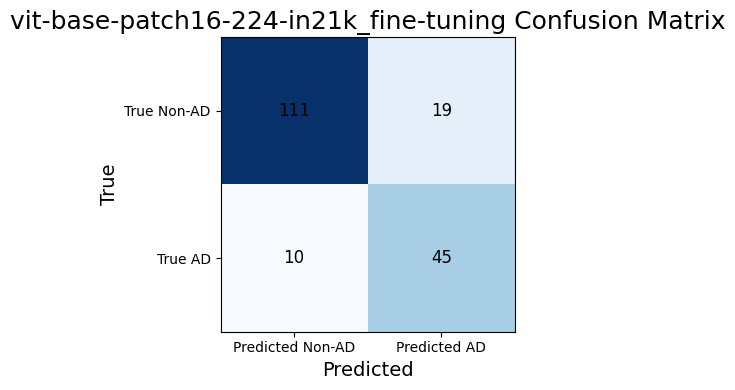

In [14]:
# Compute metrics
acc = accuracy_score(y_te, y_pred)
auc = roc_auc_score(y_te, y_prob)

# Precision and Recall
cm = confusion_matrix(y_te, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp + 1e-12)
recall = tp / (tp + fn + 1e-12)

# Display results in a DataFrame
summary_df = pd.DataFrame([{
    "Model": "vit-base-patch16-224-in21k_fine-tuning",
    "Accuracy %": round(acc*100),
    "Precision %": round(precision*100),
    "Recall %": round(recall*100),
    "AUC %": round(auc*100),
}])
display(summary_df.style.hide(axis="index"))

# Confusion matrix heatmap
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
im = ax.imshow(cm, interpolation='nearest', cmap="Blues")
ax.set_title(f"Confusion Matrix", fontsize=18)
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels([f"Predicted Non-AD", f"Predicted AD"])
ax.set_yticklabels([f"True Non-AD", f"True AD"])

# annotate counts
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
ax.set_xlabel("Predicted", fontsize=14); ax.set_ylabel("True", fontsize=14)
plt.tight_layout()
plt.show()

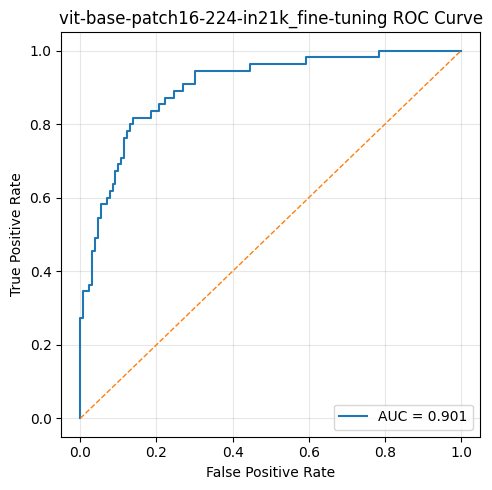

In [15]:
# ROC curve
fpr, tpr, thr = roc_curve(y_te, y_prob)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], '--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("vit-base-patch16-224-in21k_fine-tuning ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

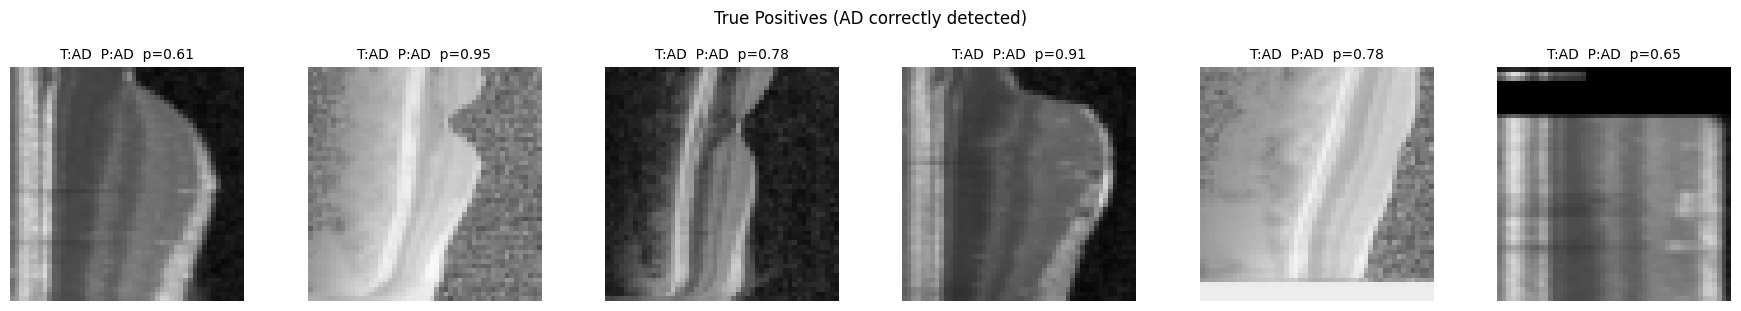

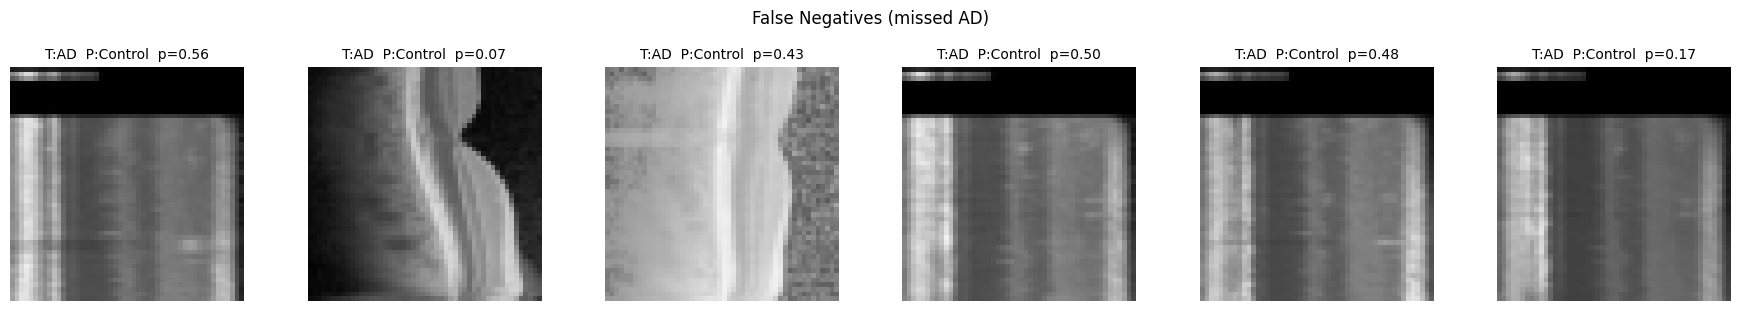

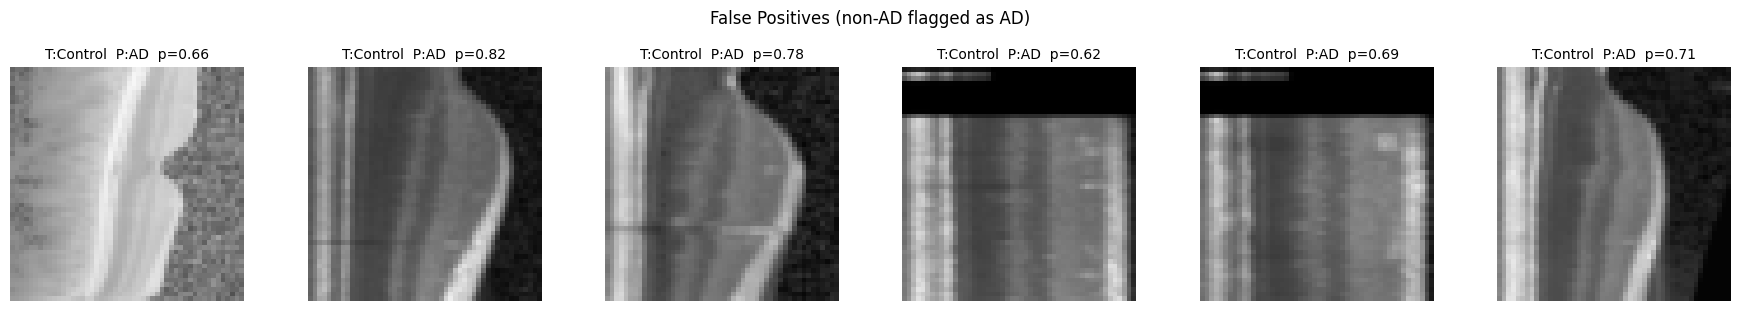

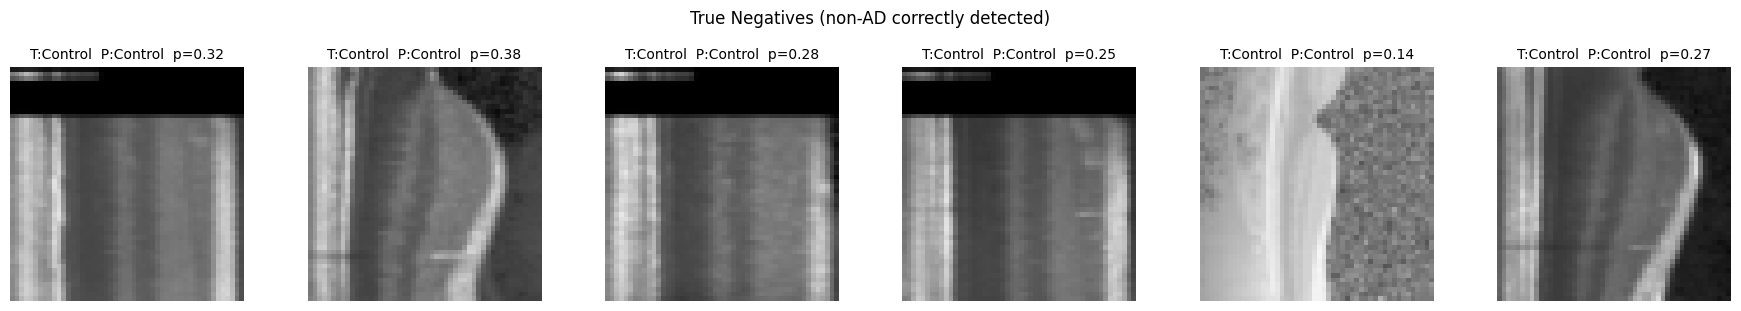

In [10]:
# Visualize some example predictions
rng = np.random.default_rng(0)
TP = np.where((y_te == 1) & (y_pred == 1))[0]
TN = np.where((y_te == 0) & (y_pred == 0))[0]
FP = np.where((y_te == 0) & (y_pred == 1))[0]
FN = np.where((y_te == 1) & (y_pred == 0))[0]

def show_examples(indices, n=8, cols=4, title=None):
    """Function show_examples to display example images with predictions

        Args:
            indices (np.ndarray): Indices of samples to display
            n (int): Number of samples to display
            cols (int): Number of columns in the display grid
            title (str or None): Title for the display

    """
    # handle empty case
    if len(indices) == 0:
        print(f"{title or 'Samples'}: none")
        return
    # randomly select n samples if more are available
    sel = indices if len(indices) <= n else rng.choice(indices, size=n, replace=False)
    rows = math.ceil(len(sel) / cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, k in enumerate(sel):
        img = X_te[k]

        # squeeze grayscale channel if present
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax.axis("off")
        ax.set_title(f"T:{class_names[int(y_te[k])]}  "
                     f"P:{class_names[int(y_pred[k])]}  "
                     f"p={y_prob[k]:.2f}",
                     fontsize=10)
    if title:
        plt.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

show_examples(TP, n=6, cols=6, title="True Positives (AD correctly detected)")
show_examples(FN, n=6, cols=6, title="False Negatives (missed AD)")
show_examples(FP, n=6, cols=6, title="False Positives (non-AD flagged as AD)")
show_examples(TN, n=6, cols=6, title="True Negatives (non-AD correctly detected)")